In [1]:
import torch, yaml
import numpy as np
import matplotlib.pyplot as plt
import bsde.metrics

# import importlib
# importlib.reload(bsde.metrics)

from pathlib import Path

from bsde.solver import DeepBSDESolverBS
from bsde.payoff import basket_call
from bsde.metrics import delta_hedge_BS
from benchmark import MC_sim_BS


cfg = yaml.safe_load(Path("experiments/config.yaml").read_text())

FileNotFoundError: [Errno 2] No such file or directory: 'experiments/config.yaml'

In [2]:
payoff_func = lambda S: basket_call(S, strike=cfg["payoff"]["K"])

In [3]:
net_cfg = dict(hidden=64, depth=3)

In [1]:
solver = DeepBSDESolverBS(
    model_params=cfg["model"],
    payoff_fn=payoff_func,
    T=cfg["T"],
    n_steps=cfg["n_steps"],
    net_cfg=cfg["net"] if "net" in cfg else net_cfg,
    lr=.5e-4,
)

NameError: name 'DeepBSDESolverBS' is not defined

In [5]:
solver.net.load_state_dict(torch.load("mod/bsde_blackscholes.pt",map_location="cpu"))
solver.net.eval()

FeedForwardNNBS(
  (fcn): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
  )
  (y_head): Linear(in_features=128, out_features=1, bias=True)
  (z_head): Linear(in_features=128, out_features=10, bias=True)
)

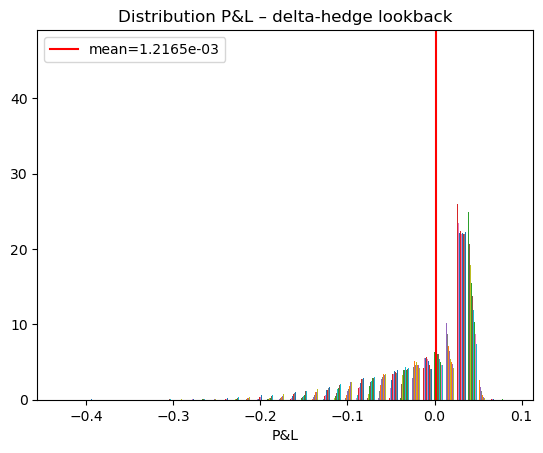

 mean  : 0.0012165323132649064
 stdev : 0.05171240493655205


In [6]:
pnl = delta_hedge_BS(
    simulator =solver.simulator,
    net       = solver.net,      
    payoff_fn = payoff_func,
    n_paths   = 10_000,             # assez pour voir la distribution
    n_steps   = cfg["n_steps"],
    T         = cfg["T"]
)

plt.hist(pnl, bins=40, density=True)
plt.axvline(pnl.mean(), color="r", label=f"mean={pnl.mean():.4e}")
plt.title("Distribution P&L – delta-hedge lookback")
plt.xlabel("P&L"); plt.legend(); plt.show()

print(" mean  :", pnl.mean().item())
print(" stdev :", pnl.std().item())

In [16]:
price_mc_bs, ci95_bs = MC_sim_BS(
    model=solver.simulator,
    payoff_fn=payoff_func,
    n_paths=10_000,
    n_steps=cfg["n_steps"],
    T=cfg["T"],
)

print(f"MC basket call | Price : {price_mc_bs} | ci : ±{ci95_bs}\n [{(price_mc_bs - ci95_bs):.2e}, {(price_mc_bs + ci95_bs):.2e}]")
print(f'BSDE Price : {solver.predict():.2e}')

MC basket call | Price : 0.04045470803976059 | ci : ±0.0010991204395890235
 [3.94e-02, 4.16e-02]
BSDE Price : 4.61e-02
